In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [33]:
reference = "atac"
subtractables = ["chip"]
intervals = [reference] + subtractables
intervals

['atac', 'chip']

In [5]:
atac = pd.read_csv("atac_mapped_translatedto5.0.csv", header=None, names=["chr","start","stop"])
chip = pd.read_csv('AlxChip_mapped_translatedto5.0.txt', sep="\t", header=None, names=["chr","start","stop"])

In [34]:
atac["type"] = "atac"
chip["type"] = "chip"
al = pd.concat([atac, chip])
all_chrs=al.chr.unique()
al["length"] = al["stop"] - al["start"]

In [8]:
#CHECK IF THERE ARE NEGATIVE NUMBERS
min(al["length"]) <= 0

False

In [9]:
#make it into a dictionary 
ranges = { interval : defaultdict(list) for interval in intervals }
for Var in intervals:
    temp_df = al[al["type"]==Var]
    for index, row in temp_df.iterrows():
        ranges[Var][row['chr']].append([row['start'],row['stop']])

In [10]:
def range_takeout(contig, evil):
    A0, A1 = contig #region that we like, e.g. conserved region, start and end respectively, start being the lower number no matter the direction of the gene for example
    B0, B1 = evil #region that we don't want in the end, e.g. coding region, start and end
    if( A1 < B0 or B1 < A0 ): # no overlap
        return [contig]
    elif ( A0 < B0 and B0 <= A1 and A1 <= B1) : # tail left
        return [[A0, B0]]
    elif (B0 <= A0 and A0 <= B1 and B1 < A1): # tail right
        return [[B1, A1]]
    elif ( B0 <= A0 and A1 <= B1): # superset
        return []
    elif (A0 < B0 and B1 < A1): # subset
        return [[A0,B0],[B1,A1]]
    else:
        print("ERROR:",contig, evil)

In [11]:
def unzip(l):
    return list(zip(*l))

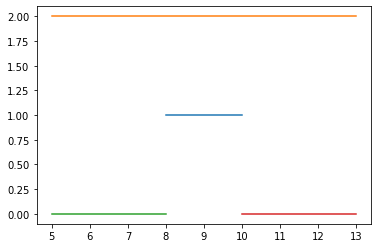

In [12]:
test_range = [8,10]
contig = [5,13]
xs,ys = unzip(list(zip(test_range,[1]*len(test_range))))
plt.plot(xs,ys)
xs,ys = unzip(list(zip(contig,[2]*len(contig))))
plt.plot(xs,ys)

for res in range_takeout(contig, test_range):
    xs,ys = unzip(list(zip(res,[0]*len(res))))
    plt.plot(xs,ys)

In [13]:
#quick check if two regions overlap
def check_overlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0])) > 0

In [14]:
def subtract_scaffold(contig, enemy, debug=False, max_safety=1e6):
    good_idx = 0
    evil_idx = 0
    safety = 0 #this is to avoid an infinite while loop

    while True and safety < max_safety:
        if(good_idx >= len(contig) or evil_idx >= len(enemy)):
            print("YOU ARE A FAILURE.")
            break
        good = contig[good_idx]
        evil = enemy[evil_idx]
        good_start, good_end = good[0], good[1]
        evil_start, evil_end = evil[0], evil[1]
        if debug:
            print(f"checking {good} {evil} :",end=" ")
        if(check_overlap(good,evil)):
            if debug:
                print("overlap")
            segments = range_takeout(good,evil)
            if debug:
                print("segments",segments)
            contig = contig[:good_idx] + segments + contig[good_idx+1:]
            if debug:
                print("new",contig[good_idx-1:good_idx+2], "current idx", contig[good_idx])
                
            if(good_idx >= len(contig) or evil_idx >= len(enemy)):
                print("extra check saved us.")
                break

        else:
            if(evil_end <= good_start):
                if debug:
                    print("evil")
                evil_idx += 1
                if(evil_idx >= len(enemy)):
                    if debug:
                        print("EVIL FINISHED")
                    break
                if debug:
                    print("next evil", enemy[evil_idx])
            else:
                if debug:
                    print("good")
                good_idx += 1
                if(good_idx >= len(contig)):
                    if debug:
                        print("GOOD FINISHED")
                    break
                if debug:
                    print("next good", contig[good_idx])

        safety += 1
    if debug:
        print(safety)
    return contig

In [15]:
#making example set for testing subtract_scaffold function.
econtigs=[[0,100],[150,170],[180,185],[190,250]]
eevil = [[80,155],[200,210]]
#desired output> [[0, 80], [155, 170], [180, 185], [190, 200], [210, 250]]

edf = pd.DataFrame(econtigs, columns = ['start', 'stop'])
edf['type']="contig"
edf['chr']="scaffoldx"
e2df = pd.DataFrame(eevil, columns = ['start', 'stop'])
e2df['type']="evil"
e2df['chr']="scaffoldx"
eal = pd.concat([edf, e2df])

eintervals = ["contig","evil"]

#make it into a dictionary 
eranges = { interval : defaultdict(list) for interval in eintervals }
for Var in eintervals:
    temp_df = eal[eal["type"]==Var]
    for index, row in temp_df.iterrows():
        eranges[Var][row['chr']].append([row['start'],row['stop']])
        
egood = eranges["contig"]
ebad = eranges["evil"]

new_contig = subtract_scaffold(egood["scaffoldx"], ebad["scaffoldx"], debug=True)
new_contig

checking [0, 100] [80, 155] : overlap
segments [[0, 80]]
new [] current idx [0, 80]
checking [0, 80] [80, 155] : good
next good [150, 170]
checking [150, 170] [80, 155] : overlap
segments [[155, 170]]
new [[0, 80], [155, 170], [180, 185]] current idx [155, 170]
checking [155, 170] [80, 155] : evil
next evil [200, 210]
checking [155, 170] [200, 210] : good
next good [180, 185]
checking [180, 185] [200, 210] : good
next good [190, 250]
checking [190, 250] [200, 210] : overlap
segments [[190, 200], [210, 250]]
new [[180, 185], [190, 200], [210, 250]] current idx [190, 200]
checking [190, 200] [200, 210] : good
next good [210, 250]
checking [210, 250] [200, 210] : evil
EVIL FINISHED
8


[[0, 80], [155, 170], [180, 185], [190, 200], [210, 250]]

In [16]:
contig = ranges["atac"]
subtract = ranges["chip"]

In [32]:
results = {}
for ch in all_chrs:
    if len(al[(al["chr"]==ch) & (al["type"]=="atac")]) > 0:
        new_contig = subtract_scaffold(contig[ch], subtract[ch], debug=False)
        results[ch] = new_contig

extra check saved us.


# some code for testing in nondraft notebook

In [ ]:
#quick testing and visualisation of how this works

A = [0, 10]
B = [15, 20]
test_intervals(A,B)

A = [15, 20]
B = [0, 10]
test_intervals(A,B)

A = [0, 10]
B = [5, 15]
test_intervals(A,B)

A = [5, 15]
B = [0, 10]
test_intervals(A,B)

A = [0, 20]
B = [5, 15]
test_intervals(A,B)

A = [5, 15]
B = [0, 10]
test_intervals(A,B)

In [ ]:
#further testing
As=[[0,10],[20,30],[70,100],[150,170],[180,185],[190,250]]
Bs = [[80,155],[200,210]]
Cs = [[80, 100], [150, 155], [200, 210]]

res = compute_overlaps(As,Bs)
print(res)
print(Cs)

## old, preLapo merging function

In [36]:
#quick check if two regions overlap
def check_overlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0])) > 0

In [37]:
def merge_scaffold(ref, toadd, debug=False, max_safety=1e6):
    ref_idx = 0
    toadd_idx = 0
    safety = 0 #this is to avoid an infinite while loop

    overlaps = []
    
    while True and safety < max_safety:
        good = ref[ref_idx]
        better = toadd[toadd_idx]
        good_start, good_end = good[0], good[1]
        better_start, better_end = better[0], better[1]
        
        if debug:
            print(f"checking {good} {better} :",end=" ")
        if(check_overlap(good,better)):
            if debug:
                print("overlap")
            segments = range_merge(good,better)
            overlaps.append(segments)
            if debug:
                print("segments",segments)
            
            if(ref_idx+1 >= len(ref) or toadd_idx+1 >= len(toadd)):
                print("reached the end")
                print(len(ref))
                print(len(toadd))
                break
            
            both = True
            
            if(ref_idx+1 < len(ref)):
                if(check_overlap(toadd[toadd_idx],ref[ref_idx+1])):
                    ref_idx += 1
                    both = False
                    print("icreased_ref")
                    
            if(toadd_idx+1 < len(toadd)):
                if(check_overlap(ref[ref_idx],toadd[toadd_idx+1])):
                    toadd_idx += 1
                    both = False
                    print("icreased_toadd")
                    
            if (both) and (toadd_idx+1 != len(toadd)) and (ref_idx+1 != len(ref)):
                ref_idx += 1
                toadd_idx += 1
                print("icreased_both")
                       
        else:
            if(ref_idx+1 >= len(ref) or toadd_idx+1 >= len(toadd)):
                print("reached the end")
                print(len(ref))
                print(len(toadd))
                break
            else:
                if good_start < better_start:
                    ref_idx += 1
                    print("icreased_ref")
                elif good_start > better_start:
                    toadd_idx += 1
                    print("icreased_toadd")
                else:
                    print("impossible, you are a moron")
        

        safety += 1
    return overlaps

In [ ]:
#making example set for testing merge_scaffold function.
econtig=[[0,10],[20,30],[70,100],[150,170],[180,185],[190,250]]
eevil = [[80,155],[200,210]]
#desired output> [[[80, 100]], [[150, 155]], [[200, 210]]]

edf = pd.DataFrame(econtig, columns = ['start', 'stop'])
edf['type']="contig"
edf['chr']="scaffoldx"
e2df = pd.DataFrame(eevil, columns = ['start', 'stop'])
e2df['type']="evil"
e2df['chr']="scaffoldx"
eal = pd.concat([edf, e2df])

eintervals = ["contig","evil"]

#make it into a dictionary 
eranges = { interval : defaultdict(list) for interval in eintervals }
for Var in eintervals:
    temp_df = eal[eal["type"]==Var]
    for index, row in temp_df.iterrows():
        eranges[Var][row['chr']].append([row['start'],row['stop']])
        
eref = eranges["contig"]
etoadd = eranges["evil"]

new_contig = merge_scaffold(eref["scaffoldx"], etoadd["scaffoldx"], debug=True)
new_contig